In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif
import os

In [3]:
# --- Schritt 1: Korrelationsanalyse und initiale Feature-Selektion ---
def remove_highly_correlated_features(df, threshold=0.9):
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    
    # Finden der hoch korrelierten Features
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# --- Schritt 2: Modelltraining und Speicherung der wichtigen Features ---
def train_and_evaluate(X, y, threshold=0.85):
    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Modell initialisieren und trainieren
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)

    # Vorhersagen und Metriken
    y_pred = log_reg.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Extraktion der wichtigen Features
    important_features = pd.Series(log_reg.coef_[0], index=X.columns)
    important_features = important_features[important_features.abs() > threshold]
    return important_features, log_reg

# --- Schritt 3: Analyse der wichtigen Features ---
def analyze_important_features(df, important_features):
    # Korrelationsmatrix für wichtige Features
    important_corr = df[important_features.index].corr()
    print("Correlation Matrix of Important Features:")
    print(important_corr)
    return important_corr


In [ ]:
# --- Anwendung der Pipeline ---
# Daten vorbereiten
path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv' 
df = pd.read_csv(path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])

target = 'daytime_encoded'
X = df.drop(columns=[target])
y = df[target]

# Initialisierung der Parameter
corr_threshold = 0.95
coef_threshold = 0.85
iterations = 3

# Ergebnisse speichern
used_features = []
current_df = X.copy()

for iteration in range(iterations):
    print(f"\n--- Iteration {iteration + 1} ---")

    # Schritt 1: Entfernen hoch korrelierter Features
    current_df, dropped_features = remove_highly_correlated_features(current_df, threshold=corr_threshold)
    print(f"Dropped Features due to high correlation: {dropped_features}")

    # Schritt 2: Modelltraining und wichtige Features speichern
    important_features, model = train_and_evaluate(current_df, y, threshold=coef_threshold)
    print(f"Important Features (>|{coef_threshold}|): {list(important_features.index)}")

    # Schritt 3: Analyse der wichtigen Features
    analyze_important_features(df, important_features)

    # Speichern der verwendeten Features
    used_features.append(list(current_df.columns))
    with open(f"features_iteration_{iteration + 1}.txt", "w") as f:
        f.write(f"Iteration {iteration + 1} Features:\n")
        f.write("\n".join(current_df.columns))

## Iterative Approach

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])
#print(df.head(2))

In [17]:
# Zielvariable und Features festlegen
target = 'daytime_encoded'
X = df.drop(columns=[target])  # Features
y = df[target]  # Zielvariable

# Trainings- und Testdaten splitten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Modelle initialisieren
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss")
}

# Ergebnisse speichern
results = []

# Iterativer Ansatz
for model_name, model in models.items():
    current_X_train = X_train.copy()
    iteration = 0

    while current_X_train.shape[1] > 40:  # Solange noch mindestens ein Feature übrig ist
        # Pipeline erstellen (Skalierung und Modell)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardisierung
            ('model', model)
        ])

        # Modell trainieren
        pipeline.fit(current_X_train, y_train)

        # Wichtigste Features extrahieren
        if model_name == "LogisticRegression":
            importance = np.abs(model.coef_[0])  # Gewichtungen der Features
        elif model_name == "RandomForest" or model_name == "XGBoost":
            importance = model.feature_importances_

        important_features = pd.Series(importance, index=current_X_train.columns)
        important_features = important_features.sort_values(ascending=False)

        # Genauigkeit berechnen
        y_pred = pipeline.predict(X_test[current_X_train.columns])
        accuracy = accuracy_score(y_test, y_pred)
        confusionmatrix = confusion_matrix(y_test, y_pred)

        # Ergebnis speichern
        results.append({
            "Model": model_name,
            "Iteration": iteration,
            "Accuracy": accuracy,
            "Confusion Matrix": confusionmatrix,
            "Dropped Feature": important_features.index[0],
            "Feature Importance": important_features.iloc[0],
            "Remaining Features": len(current_X_train.columns)
        })

        # Ausgabe in der Konsole
        print(f"Model: {model_name}, Iteration: {iteration}, Accuracy: {accuracy:.4f}, Confusion Mx: {confusionmatrix}"
              f"Dropped Feature: {important_features.index[0]}, Feature Importance: {important_features.iloc[0]:.4f}")

        # Ergebnis in Datei speichern
        with open(f"{model_name}_feature_dropping_results.txt", "a") as file:
            file.write(f"Iteration: {iteration}, Accuracy: {accuracy:.4f}, "
                       f"Confusion Matrix: {confusionmatrix}, "
                       f"Dropped Feature: {important_features.index[0]}, "
                       f"Feature Importance: {important_features.iloc[0]:.4f}, "
                       f"Remaining Features: {len(current_X_train.columns)}\n")

        # Wichtigstes Feature droppen
        current_X_train = current_X_train.drop(columns=[important_features.index[0]])

        # Iteration erhöhen
        iteration += 1

# Ergebnisse als DataFrame anzeigen
results_df = pd.DataFrame(results)
print("\nAbschließende Ergebnisse:\n", results_df)


Model: LogisticRegression, Iteration: 0, Accuracy: 0.9053, Confusion Mx: [[1525  117]
 [ 149 1018]]Dropped Feature: mfcc_2, Feature Importance: 2.3759
Model: LogisticRegression, Iteration: 1, Accuracy: 0.9078, Confusion Mx: [[1530  112]
 [ 147 1020]]Dropped Feature: band_24_dB, Feature Importance: 2.8380
Model: LogisticRegression, Iteration: 2, Accuracy: 0.9078, Confusion Mx: [[1533  109]
 [ 150 1017]]Dropped Feature: band_25_dB, Feature Importance: 2.2989
Model: LogisticRegression, Iteration: 3, Accuracy: 0.9078, Confusion Mx: [[1533  109]
 [ 150 1017]]Dropped Feature: band_19_dB, Feature Importance: 1.8524
Model: LogisticRegression, Iteration: 4, Accuracy: 0.9064, Confusion Mx: [[1532  110]
 [ 153 1014]]Dropped Feature: band_26_dB, Feature Importance: 1.6340
Model: LogisticRegression, Iteration: 5, Accuracy: 0.9060, Confusion Mx: [[1530  112]
 [ 152 1015]]Dropped Feature: channel_encoded, Feature Importance: 1.6536
Model: LogisticRegression, Iteration: 6, Accuracy: 0.9057, Confusion 

In [ ]:
# Zielvariable und Features festlegen
target = 'daytime_encoded'
X = df.drop(columns=[target])  # Features
y = df[target]  # Zielvariable

# Trainings- und Testdaten splitten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Modelle initialisieren
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss")
}

# Ergebnisse speichern
results = []
deleted_features_logreg = []
deleted_features_rf = []
deleted_features_xgb = []

# Iterativer Ansatz
for model_name, model in models.items():
    current_X_train = X_train.copy()
    iteration = 0

    while current_X_train.shape[1] > 40:  # Solange noch mindestens ein Feature übrig ist
        # Pipeline erstellen (Skalierung und Modell)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardisierung
            ('model', model)
        ])

        # Modell trainieren
        pipeline.fit(current_X_train, y_train)

        # Wichtigste Features extrahieren
        if model_name == "LogisticRegression":
            importance = np.abs(model.coef_[0])  # Gewichtungen der Features
        elif model_name == "RandomForest" or model_name == "XGBoost":
            importance = model.feature_importances_

        important_features = pd.Series(importance, index=current_X_train.columns)
        important_features = important_features.sort_values(ascending=False)

        # Genauigkeit berechnen
        y_pred = pipeline.predict(X_test[current_X_train.columns])
        accuracy = accuracy_score(y_test, y_pred)
        confusionmatrix = confusion_matrix(y_test, y_pred)

        # Ergebnis speichern
        results.append({
            "Model": model_name,
            "Iteration": iteration,
            "Accuracy": accuracy,
            "Confusion Matrix": confusionmatrix,
            "Dropped Feature": important_features.index[0],
            "Feature Importance": important_features.iloc[0],
            "Remaining Features": len(current_X_train.columns)
        })

        # Entfernte Features pro Modell speichern
        if model_name == "LogisticRegression":
            deleted_features_logreg.append(important_features.index[0])
        elif model_name == "RandomForest":
            deleted_features_rf.append(important_features.index[0])
        elif model_name == "XGBoost":
            deleted_features_xgb.append(important_features.index[0])

        # Ausgabe in der Konsole
        print(f"Model: {model_name}, Iteration: {iteration}, Accuracy: {accuracy:.4f}, Confusion Mx: {confusionmatrix} "
              f"Dropped Feature: {important_features.index[0]}, Feature Importance: {important_features.iloc[0]:.4f}")

        # Ergebnis in Datei speichern
        with open(f"{model_name}_feature_dropping_results.txt", "a") as file:
            file.write(f"Iteration: {iteration}, Accuracy: {accuracy:.4f}, "
                       f"Confusion Matrix: {confusionmatrix}, "
                       f"Dropped Feature: {important_features.index[0]}, "
                       f"Feature Importance: {important_features.iloc[0]:.4f}, "
                       f"Remaining Features: {len(current_X_train.columns)}\n")

        # Wichtigstes Feature droppen
        current_X_train = current_X_train.drop(columns=[important_features.index[0]])

        # Iteration erhöhen
        iteration += 1

# Ergebnisse als DataFrame anzeigen
results_df = pd.DataFrame(results)
print("\nAbschließende Ergebnisse:\n", results_df)


Model: LogisticRegression, Iteration: 0, Accuracy: 0.9053, Confusion Mx: [[1525  117]
 [ 149 1018]] Dropped Feature: mfcc_2, Feature Importance: 2.3759
Model: LogisticRegression, Iteration: 1, Accuracy: 0.9078, Confusion Mx: [[1530  112]
 [ 147 1020]] Dropped Feature: band_24_dB, Feature Importance: 2.8380
Model: LogisticRegression, Iteration: 2, Accuracy: 0.9078, Confusion Mx: [[1533  109]
 [ 150 1017]] Dropped Feature: band_25_dB, Feature Importance: 2.2989
Model: LogisticRegression, Iteration: 3, Accuracy: 0.9078, Confusion Mx: [[1533  109]
 [ 150 1017]] Dropped Feature: band_19_dB, Feature Importance: 1.8524
Model: LogisticRegression, Iteration: 4, Accuracy: 0.9064, Confusion Mx: [[1532  110]
 [ 153 1014]] Dropped Feature: band_26_dB, Feature Importance: 1.6340
Model: LogisticRegression, Iteration: 5, Accuracy: 0.9060, Confusion Mx: [[1530  112]
 [ 152 1015]] Dropped Feature: channel_encoded, Feature Importance: 1.6536
Model: LogisticRegression, Iteration: 6, Accuracy: 0.9057, Conf

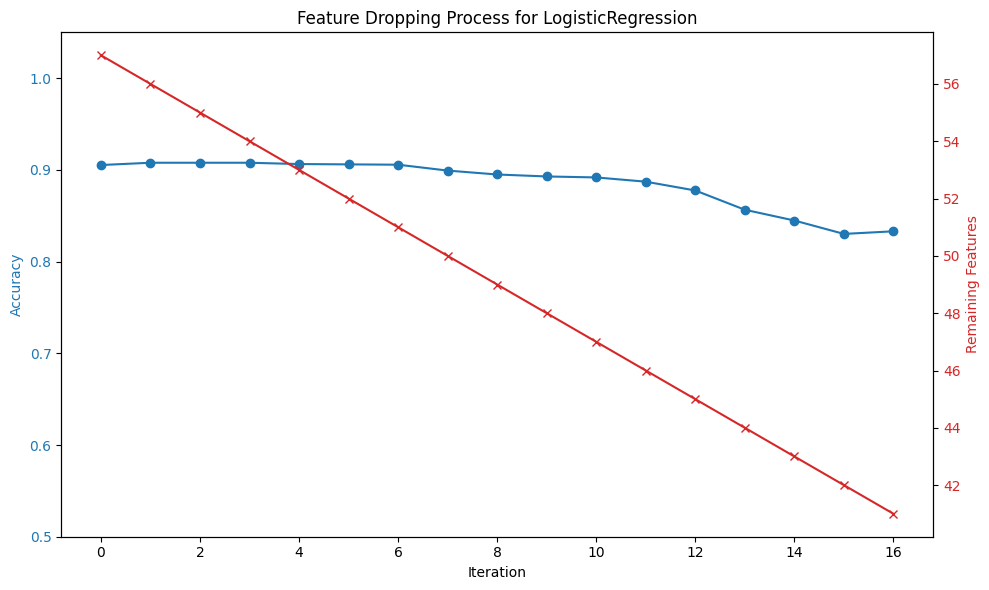

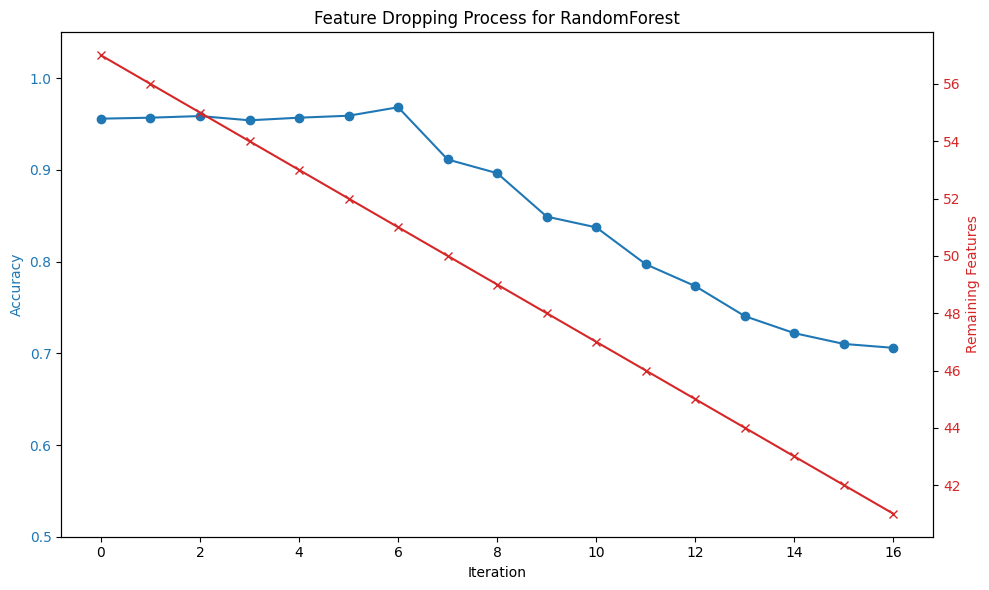

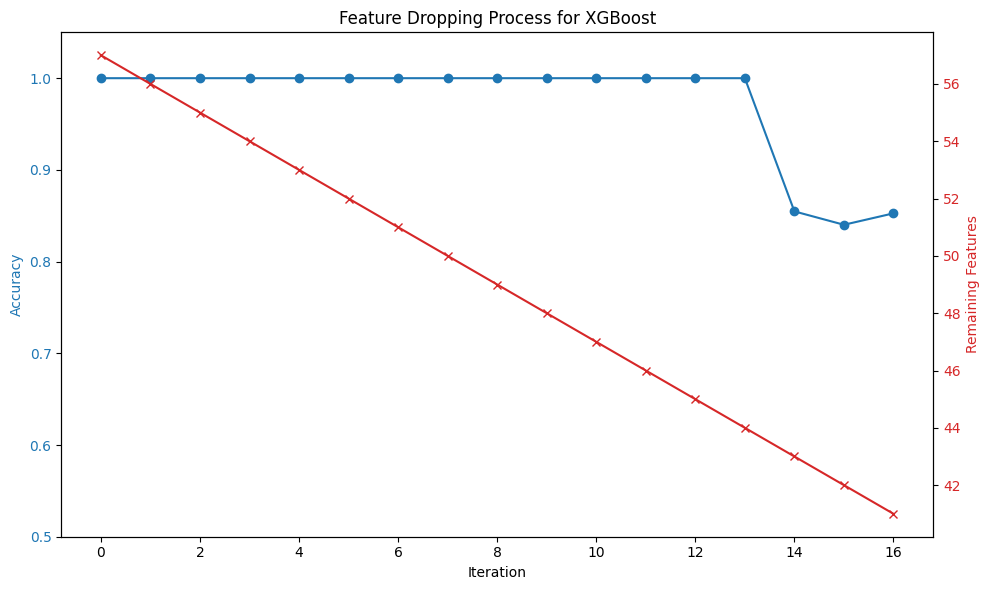

In [8]:
# Visualization
def plot_feature_dropping(results_df, model_name):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Primäre Achse: Genauigkeit
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(results_df['Iteration'], results_df['Accuracy'], label='Accuracy', color='tab:blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0.5, 1.05)  # Grenzen der Accuracy anpassen

    # Sekundäre Achse: Anzahl der verbleibenden Features
    ax2 = ax1.twinx()
    ax2.set_ylabel('Remaining Features', color='tab:red')
    ax2.plot(results_df['Iteration'], results_df['Remaining Features'], label='Remaining Features', color='tab:red', marker='x')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Titel und Legende
    plt.title(f"Feature Dropping Process for {model_name}")
    fig.tight_layout()  # Layout anpassen
    plt.show()


# Visualisierung für jedes Modell separat
for model_name in models.keys():
    model_results_df = results_df[results_df['Model'] == model_name]
    plot_feature_dropping(model_results_df, model_name)

Notes: 

Performance of Logistic Regression is not really improved by feature deletion. Deletion of features 1-6 bring slight or no changes with feature 6 being location_encoded.

All deleted Features for improvement: 

mfcc_2
band_24_dB
band_25_dB
band_19_dB
band_26_dB
channel_encoded
location_encoded
mfcc_3
band_29_dB
band_28_dB


Performance of Random Forest is improved by feature deletion of features 0-6 with feature six being date_time_encoded.

All deleted Features for improvement: 

mfcc_2            
band_29_dB            
band_28_dB            
band_27_dB 
mfcc_1              
band_26_dB            
date_time_encoded

XG Bosst has a problem because of accuracy = 100%. Performance of XG Boost can by normalized by feature deletion of features 1-13 with feature 13 being date_time_encoded.

All deleted Features for improvement: 

mfcc_8
band_29_dB
band_28_dB
mfcc_2
mfcc_1
channel_encoded
band_27_dB
peak_dB_3
band_26_dB
location_encoded
mfcc_3
band_25_dB
weather_encoded
band_14_dB
date_time_encoded

the feature date_time_encoded has high importance as it leads to drastic changes in performance for 2 models!!! it needs to be removed.


### Save most important features for removal in data input  

In [10]:
# Vergleich der ersten n Features
n = 14
common_features = set(deleted_features_logreg[:n]) & set(deleted_features_rf[:n]) & set(deleted_features_xgb[:n])

# Gemeinsame Features speichern
common_features_df = pd.DataFrame(list(common_features), columns=["Common Features"])

new_entry = pd.DataFrame([["date_time_encoded"]], columns=["Common Features"])
common_features_df = pd.concat([common_features_df, new_entry], ignore_index=True)

common_features_df.to_csv("common_features.csv", index=False)

print(f"\nGemeinsame Features der ersten {n} Einträge sind:\n", common_features_df)


Gemeinsame Features der ersten 14 Einträge sind:
      Common Features
0         band_26_dB
1         band_27_dB
2         band_28_dB
3             mfcc_3
4             mfcc_2
5         band_25_dB
6         band_29_dB
7  date_time_encoded
